In [1]:
from IPython.display import clear_output
import sys

IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:

    !pip install gymnasium moviepy

    clear_output()
else:
    from os import path
    sys.path.append( path.dirname( path.dirname( path.abspath("__main__") ) ) )

In [2]:
import gymnasium as gym
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

In [3]:
VERBOSE = True

# Configurações
# NOME_AMBIENTE = "CliffWalking-v0"
EPISODIOS = 3000
TAXA_APRENDIZADO = 0.2
DESCONTO = 0.95
EPSILON = 0.1
TEMPERATURA = 1.0

import envs #importa racetrack
envs = {
    "Cliffwalking": "CliffWalking-v0",
    "Frozen": "FrozenLake-v1",
    "Taxi": "Taxi-v3",
    "Racetrack": "RaceTrack-v0"  # ensure this env exists or adjust accordingly
}

In [4]:
def plot_multiple_results(resultados, log_scale=False):
    for grupo_nome, grupo_dados in resultados.items():

        plt.figure(figsize=(12, 6))
        plt.title(f"Resultados do grupo: {grupo_nome}")

        for politica_nome, recompensas in grupo_dados.items():
            plt.plot(recompensas, label=politica_nome)

        plt.xlabel("Episódios")
        plt.ylabel("Recompensas")
        if log_scale:
            plt.yscale('log')
        plt.legend()
        plt.show()

In [5]:
# Politicas

def politica_epsilon_gulosa(Q, estado, num_acoes, epsilon):
    probabilidades = [ (epsilon / num_acoes) ] * num_acoes
    acao_gulosa = np.argmax(Q[estado])
    probabilidades[acao_gulosa] += (1.0 - epsilon)
    return probabilidades

def politica_softmax(Q, estado, temperatura=1.0):
    valores_exp = np.exp(Q[estado] / temperatura)
    return valores_exp / np.sum(valores_exp)

def selecionar_acao(Q, estado, politica, **kwargs):
    probabilidades = politica(Q, estado, **kwargs)
    return np.random.choice(len(probabilidades), p=probabilidades)

In [6]:
def executar_expected_sarsa(ambiente, episodios, taxa_aprendizado=0.1, desconto=0.95,
                          politica_treinamento=politica_epsilon_gulosa, politica_alvo=politica_epsilon_gulosa,
                          parametros_politica=None, exibir=False):
    num_acoes = ambiente.action_space.n
    Q = np.zeros((ambiente.observation_space.n, num_acoes))
    recompensas_por_episodio = []

    parametros_politica = parametros_politica or {}

    for i in tqdm(range(episodios), desc="Treinando Expected-SARSA"):
        concluido = False
        recompensa_total = 0
        estado, _ = ambiente.reset()

        while not concluido:
            if exibir and (i >= (episodios - 5) or (i+1) % 1000 == 0):
                ambiente.render()

            acao = selecionar_acao(Q, estado, politica_treinamento, **parametros_politica)
            proximo_estado, recompensa, terminou, truncado, _ = ambiente.step(acao)
            concluido = terminou or truncado

            # Cálculo do valor esperado usando a política alvo
            if terminou:
                valor_proximo_estado = 0
            else:
                prob_alvo = politica_alvo(Q, proximo_estado, **parametros_politica)
                valor_proximo_estado = np.sum(prob_alvo * Q[proximo_estado])

            # Atualização Q-value
            delta = (recompensa + desconto * valor_proximo_estado) - Q[estado, acao]
            Q[estado, acao] += taxa_aprendizado * delta

            recompensa_total += recompensa
            estado = proximo_estado

        recompensas_por_episodio.append(recompensa_total)
    print("Treinamento concluído. Resultado médio: ", np.mean(recompensas_por_episodio))
    return recompensas_por_episodio, Q


In [7]:
def executar_experimentos(nome_ambiente, episodios, taxa_aprendizado, desconto, epsilon, temperatura):
    ambiente = gym.make(nome_ambiente, max_episode_steps=500)

    politicas = {
        "epsilon-gulosa": lambda Q, s, **kw: politica_epsilon_gulosa(Q, s, num_acoes=len(Q[s]), epsilon=kw['epsilon']),
        "softmax": lambda Q, s, **kw: politica_softmax(Q, s, temperatura=kw['temperatura']),
        "aleatoria": lambda Q, s, **kw: np.ones(len(Q[s])) / len(Q[s])
    }

    grupos = [
        ("1) TODOS x random", "aleatoria"),
        ("2) TODOS x epsilon-greedy", "epsilon-gulosa"),
        ("3) TODOS x softmax", "softmax")
    ]

    resultados = {}

    # Executar experimentos para cada grupo
    for nome_grupo, politica_alvo_nome in grupos:
        print(f"\n=== {nome_grupo} ===")
        grupo_resultados = {}

        for politica_treinamento_nome in politicas:
            print(f"Executando {politica_treinamento_nome} x {politica_alvo_nome}...")

            recompensas, _ = executar_expected_sarsa(
                ambiente, episodios, taxa_aprendizado, desconto,
                politicas[politica_treinamento_nome],
                politicas[politica_alvo_nome],
                {"epsilon": epsilon, "temperatura": temperatura}
            )

            grupo_resultados[f"{politica_treinamento_nome}"] = recompensas

        resultados[nome_grupo] = grupo_resultados

    # Identificar melhores de cada grupo
    final_results = {}
    for grupo_nome, grupo_dados in resultados.items():
        medias = {k: np.mean(v[-100:]) for k, v in grupo_dados.items()}  # Média dos últimos 100 episódios
        melhor = max(medias, key=medias.get)
        final_results[f"{grupo_nome} ({melhor})"] = grupo_dados[melhor]

    resultados["FINAL) Melhores de cada grupo"] = final_results

    return resultados

In [8]:
results_per_env = {}

# Run experiments for each environment using the function from [`executar_experimentos`](Expected_SARSA_off_Policy.ipynb)
for env_label, env_name in envs.items():
    print(f"Running experiments for {env_label}")
    results = executar_experimentos(env_name, EPISODIOS, TAXA_APRENDIZADO, DESCONTO, EPSILON, TEMPERATURA)
    results_per_env[env_label] = results
    print("==================================================================")

Running experiments for Cliffwalking

=== 1) TODOS x random ===
Executando epsilon-gulosa x aleatoria...


Treinando Expected-SARSA: 100%|██████████| 3000/3000 [00:03<00:00, 811.56it/s]


Treinamento concluído. Resultado médio:  -27.353
Executando softmax x aleatoria...


Treinando Expected-SARSA: 100%|██████████| 3000/3000 [00:07<00:00, 413.17it/s]


Treinamento concluído. Resultado médio:  -37.599333333333334
Executando aleatoria x aleatoria...


Treinando Expected-SARSA: 100%|██████████| 3000/3000 [01:40<00:00, 29.96it/s]


Treinamento concluído. Resultado médio:  -4989.729333333334

=== 2) TODOS x epsilon-greedy ===
Executando epsilon-gulosa x epsilon-gulosa...


Treinando Expected-SARSA: 100%|██████████| 3000/3000 [00:02<00:00, 1042.95it/s]


Treinamento concluído. Resultado médio:  -23.621666666666666
Executando softmax x epsilon-gulosa...


Treinando Expected-SARSA: 100%|██████████| 3000/3000 [00:06<00:00, 462.91it/s]


Treinamento concluído. Resultado médio:  -37.873333333333335
Executando aleatoria x epsilon-gulosa...


Treinando Expected-SARSA: 100%|██████████| 3000/3000 [01:19<00:00, 37.73it/s]


Treinamento concluído. Resultado médio:  -4988.724

=== 3) TODOS x softmax ===
Executando epsilon-gulosa x softmax...


Treinando Expected-SARSA: 100%|██████████| 3000/3000 [00:02<00:00, 1007.87it/s]


Treinamento concluído. Resultado médio:  -48.388666666666666
Executando softmax x softmax...


Treinando Expected-SARSA: 100%|██████████| 3000/3000 [00:05<00:00, 525.44it/s]


Treinamento concluído. Resultado médio:  -27.755
Executando aleatoria x softmax...


Treinando Expected-SARSA: 100%|██████████| 3000/3000 [01:42<00:00, 29.17it/s]


Treinamento concluído. Resultado médio:  -4958.930666666667
Running experiments for Frozen

=== 1) TODOS x random ===
Executando epsilon-gulosa x aleatoria...


Treinando Expected-SARSA: 100%|██████████| 3000/3000 [00:02<00:00, 1291.72it/s]


Treinamento concluído. Resultado médio:  0.0
Executando softmax x aleatoria...


Treinando Expected-SARSA: 100%|██████████| 3000/3000 [00:01<00:00, 1987.42it/s]


Treinamento concluído. Resultado médio:  0.013333333333333334
Executando aleatoria x aleatoria...


Treinando Expected-SARSA: 100%|██████████| 3000/3000 [00:01<00:00, 1795.95it/s]


Treinamento concluído. Resultado médio:  0.012

=== 2) TODOS x epsilon-greedy ===
Executando epsilon-gulosa x epsilon-gulosa...


Treinando Expected-SARSA: 100%|██████████| 3000/3000 [00:02<00:00, 1393.93it/s]


Treinamento concluído. Resultado médio:  0.0
Executando softmax x epsilon-gulosa...


Treinando Expected-SARSA: 100%|██████████| 3000/3000 [00:01<00:00, 2154.92it/s]


Treinamento concluído. Resultado médio:  0.018
Executando aleatoria x epsilon-gulosa...


Treinando Expected-SARSA: 100%|██████████| 3000/3000 [00:01<00:00, 2537.22it/s]


Treinamento concluído. Resultado médio:  0.013666666666666667

=== 3) TODOS x softmax ===
Executando epsilon-gulosa x softmax...


Treinando Expected-SARSA: 100%|██████████| 3000/3000 [00:02<00:00, 1216.96it/s]


Treinamento concluído. Resultado médio:  0.0
Executando softmax x softmax...


Treinando Expected-SARSA: 100%|██████████| 3000/3000 [00:01<00:00, 1927.24it/s]


Treinamento concluído. Resultado médio:  0.015
Executando aleatoria x softmax...


Treinando Expected-SARSA: 100%|██████████| 3000/3000 [00:01<00:00, 1871.09it/s]


Treinamento concluído. Resultado médio:  0.013666666666666667
Running experiments for Taxi

=== 1) TODOS x random ===
Executando epsilon-gulosa x aleatoria...


Treinando Expected-SARSA: 100%|██████████| 3000/3000 [00:12<00:00, 245.23it/s]


Treinamento concluído. Resultado médio:  -67.53533333333333
Executando softmax x aleatoria...


Treinando Expected-SARSA: 100%|██████████| 3000/3000 [00:17<00:00, 167.22it/s]


Treinamento concluído. Resultado médio:  -99.04566666666666
Executando aleatoria x aleatoria...


Treinando Expected-SARSA: 100%|██████████| 3000/3000 [01:41<00:00, 29.42it/s]


Treinamento concluído. Resultado médio:  -1832.5706666666667

=== 2) TODOS x epsilon-greedy ===
Executando epsilon-gulosa x epsilon-gulosa...


Treinando Expected-SARSA: 100%|██████████| 3000/3000 [00:05<00:00, 562.80it/s] 


Treinamento concluído. Resultado médio:  -21.152
Executando softmax x epsilon-gulosa...


Treinando Expected-SARSA: 100%|██████████| 3000/3000 [00:09<00:00, 331.85it/s]


Treinamento concluído. Resultado médio:  -33.19266666666667
Executando aleatoria x epsilon-gulosa...


Treinando Expected-SARSA: 100%|██████████| 3000/3000 [01:47<00:00, 27.91it/s]


Treinamento concluído. Resultado médio:  -1819.5056666666667

=== 3) TODOS x softmax ===
Executando epsilon-gulosa x softmax...


Treinando Expected-SARSA: 100%|██████████| 3000/3000 [00:06<00:00, 495.64it/s] 


Treinamento concluído. Resultado médio:  -22.151666666666667
Executando softmax x softmax...


Treinando Expected-SARSA: 100%|██████████| 3000/3000 [00:08<00:00, 349.68it/s] 


Treinamento concluído. Resultado médio:  -31.487
Executando aleatoria x softmax...


Treinando Expected-SARSA: 100%|██████████| 3000/3000 [01:47<00:00, 27.94it/s]


Treinamento concluído. Resultado médio:  -1821.473
Running experiments for Racetrack

=== 1) TODOS x random ===
Executando epsilon-gulosa x aleatoria...


Treinando Expected-SARSA: 100%|██████████| 3000/3000 [00:21<00:00, 140.89it/s]


Treinamento concluído. Resultado médio:  -89.737
Executando softmax x aleatoria...


Treinando Expected-SARSA: 100%|██████████| 3000/3000 [00:29<00:00, 102.30it/s]


Treinamento concluído. Resultado médio:  -120.79566666666666
Executando aleatoria x aleatoria...


Treinando Expected-SARSA: 100%|██████████| 3000/3000 [00:43<00:00, 69.51it/s]


Treinamento concluído. Resultado médio:  -187.07466666666667

=== 2) TODOS x epsilon-greedy ===
Executando epsilon-gulosa x epsilon-gulosa...


Treinando Expected-SARSA: 100%|██████████| 3000/3000 [00:21<00:00, 137.09it/s]


Treinamento concluído. Resultado médio:  -91.93833333333333
Executando softmax x epsilon-gulosa...


Treinando Expected-SARSA: 100%|██████████| 3000/3000 [00:35<00:00, 83.84it/s] 


Treinamento concluído. Resultado médio:  -135.531
Executando aleatoria x epsilon-gulosa...


Treinando Expected-SARSA: 100%|██████████| 3000/3000 [00:48<00:00, 61.57it/s]


Treinamento concluído. Resultado médio:  -185.449

=== 3) TODOS x softmax ===
Executando epsilon-gulosa x softmax...


Treinando Expected-SARSA: 100%|██████████| 3000/3000 [00:22<00:00, 135.26it/s]


Treinamento concluído. Resultado médio:  -89.972
Executando softmax x softmax...


Treinando Expected-SARSA: 100%|██████████| 3000/3000 [00:30<00:00, 96.88it/s] 


Treinamento concluído. Resultado médio:  -126.19666666666667
Executando aleatoria x softmax...


Treinando Expected-SARSA: 100%|██████████| 3000/3000 [00:47<00:00, 63.43it/s]

Treinamento concluído. Resultado médio:  -192.31


In [9]:
def plot_grouped_results(resultados, log_scale=False):
    num_groups = len(resultados)
    # Create one subplot per group in the same figure
    fig, axes = plt.subplots(1, num_groups, figsize=(6 * num_groups, 5)) if num_groups > 1 else plt.subplots(figsize=(6, 5))
    if num_groups == 1:
        axes = [axes]
        
    for ax, (grupo_nome, grupo_dados) in zip(axes, resultados.items()):
         ax.set_title(f"Resultados do grupo: {grupo_nome}")
         for politica_nome, recompensas in grupo_dados.items():
             ax.plot(recompensas, label=politica_nome)
         ax.set_xlabel("Episódios")
         ax.set_ylabel("Recompensas")
         if log_scale:
             ax.set_yscale("log")
         ax.legend()
    plt.tight_layout()
    plt.show()

Plotting results for Cliffwalking


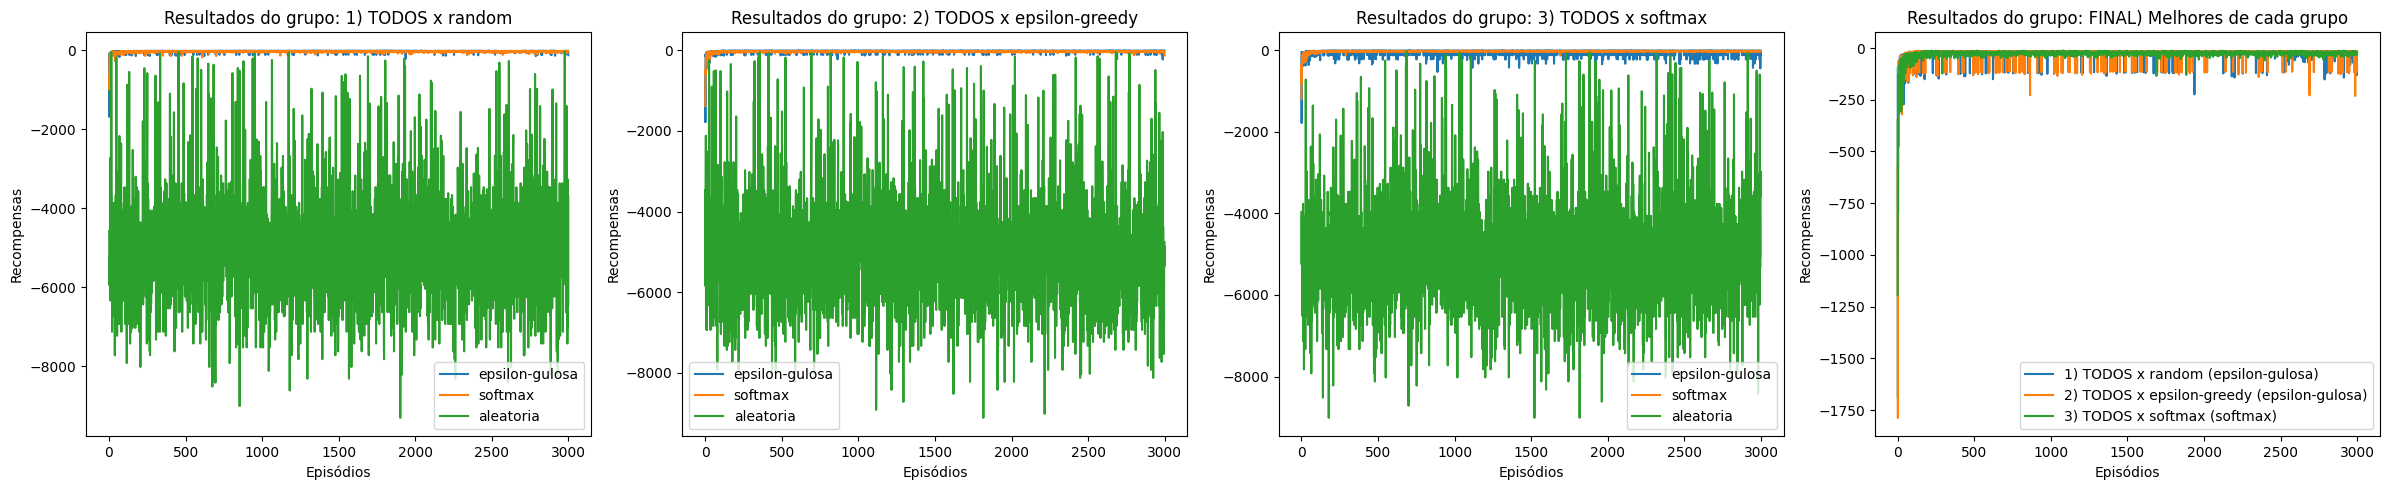

Plotting results for Frozen


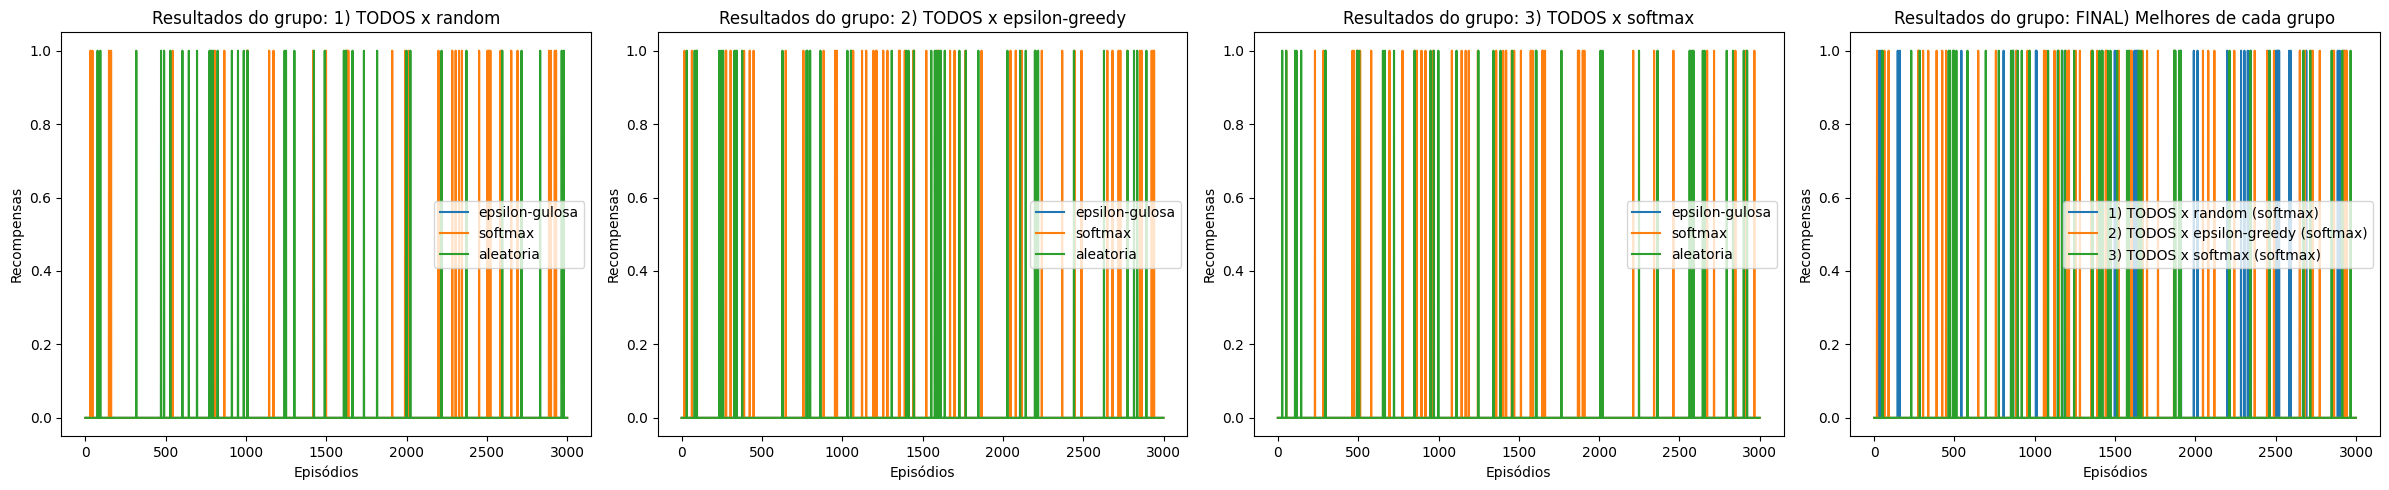

Plotting results for Taxi


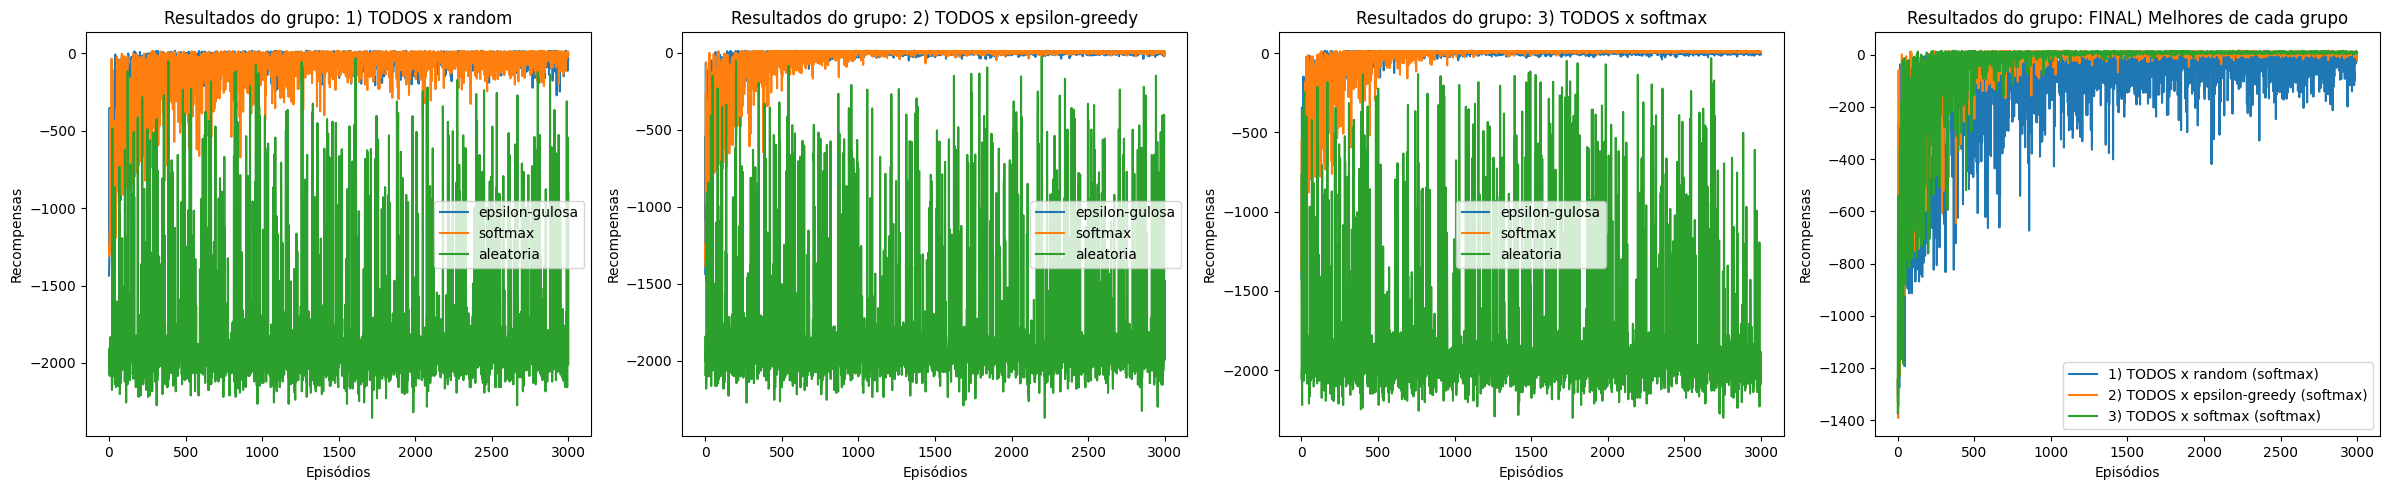

Plotting results for Racetrack


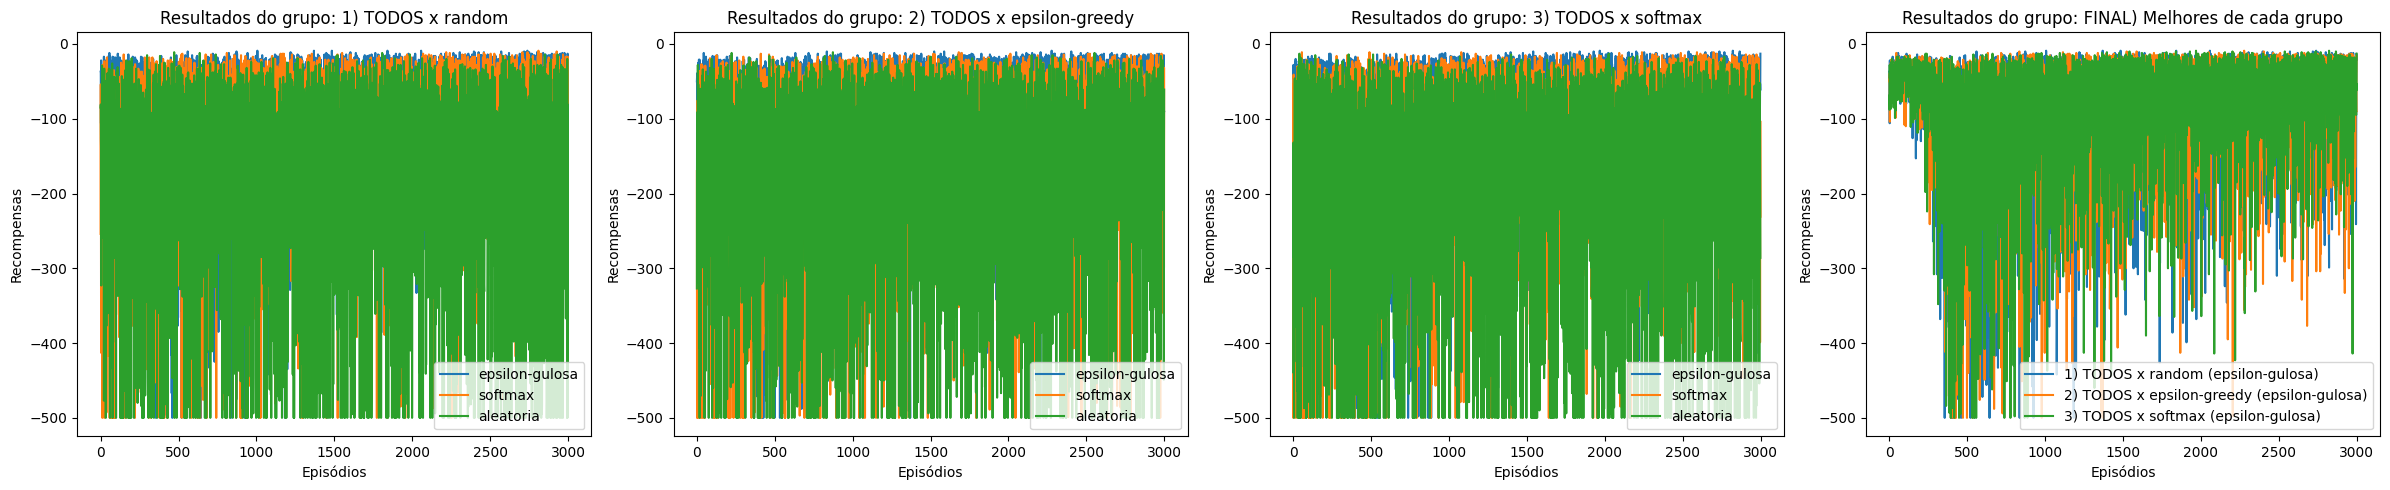

In [12]:
for env_label, env_results in results_per_env.items():
    print(f"Plotting results for {env_label}")
    plot_grouped_results(env_results, log_scale=False)